In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import torch
from heat_solver import HeatSolver, solve_heat_equation
from inverse_solver import InverseSolver
from utils import create_conductivity_field, _boundary_mask, sine_source, compute_l2_error, r2_score, visualize_solution, compute_relative_error

from utils import verification_source, verification_solution

from utils import SimpleSigma, SigmoidSigma

from run import get_boundary_conditions

# Test

In [27]:
# === Params ===
M = 20
T = 1.0
device = 'cpu'
max_sigma = 5
alpha = 0.000
sigma_0 = 1.0  # Initial guess
lr = 1e-1
omega = 2.0 * 3.1415   # Frequency for sine source
noise_level = 0.0000
max_iters = 5000
tol = 1e-3
pattern = 'linear'

source_func = lambda x, y, t: sine_source(x, y, t, omega)
sigma_gt = create_conductivity_field(M, pattern=pattern, device=device)

In [4]:
# Generate boundary observations with noise
u_b_gt = get_boundary_conditions(sigma_gt, source_func, T, max_sigma, device=device)
u_b = (1 + noise_level * torch.randn_like(u_b_gt)) * u_b_gt

## Test boundary conditions

In [ ]:
source_func = lambda x, y, t: verification_source(x, y, t, sigma_0)
sigma_gt = create_conductivity_field(M, pattern="constant", device=device)

In [ ]:
M = sigma_gt.shape[0]
solver = HeatSolver(M, source_func, device)
_, u_b_history = solver(sigma_gt, T, max_sigma=max_sigma)

In [44]:
u_b_history.shape

torch.Size([16001, 76])

In [48]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

mask = _boundary_mask(M, device)
u_b_th = torch.zeros(u_b_history.shape)
for i in range(u_b_history.shape[0]):
    u_b_th[i] = verification_solution(X, Y, i*solver.tau)[mask]

In [63]:
print((u_b_th - u_b_history).square().mean())

tensor(2.9380e-07)


# Test again

In [54]:
M = 10  # Grid size
T = 1.0  # Total time
device = 'cpu'

# Create constant conductivity field
sigma = create_conductivity_field(M, pattern='constant', device=device)
sigma.requires_grad_(True)

# Solve heat equation
print("Solving heat equation...")
u_final, u_history = solve_heat_equation(
    sigma, verification_source, M, T, device=device
)

# Compute analytical solution at final time
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

u_analytical = verification_solution(X, Y, T)

# Compute errors
l2_error = compute_l2_error(u_final, u_analytical)
relative_error = compute_relative_error(u_final, u_analytical)

Solving heat equation...
N time steps 801
Grid: 10x10, Time step: 0.001248, Steps: 801


In [55]:
print(l2_error, relative_error)

tensor(0.0025, grad_fn=<SqrtBackward0>) tensor(0.0080, grad_fn=<DivBackward0>)


## Test loss

In [5]:
sigma = SimpleSigma(M, sigma_0)

In [21]:
torch.min(sigma())

tensor(0.6929, grad_fn=<MinBackward1>)

In [22]:
solver = HeatSolver(M, source_func, device)
_, u_b_history = solver(2*sigma(), T, max_sigma=max_sigma)

In [23]:
print(solver.h, solver.tau)

0.05 6.250000000000001e-05


In [24]:
print((u_b_history - u_b).square().sum() * solver.h * solver.tau)

tensor(0., grad_fn=<MulBackward0>)


In [25]:
torch.max(u_b_history)

tensor(0.3183, grad_fn=<MaxBackward1>)

In [ ]:


loss_data = self.solver.h * self.solver.tau * (u_b_history - self.u_b_gt).square().sum()

In [19]:
# Inverse solver
inverse_solver = InverseSolver(
    sigma,
    u_b_gt=u_b,
    source_func=source_func,
    M=M,
    T=T,
    n_steps=u_b.shape[0] - 1,
    alpha=alpha,
    sigma_0=sigma_0,
    device=device
)

In [20]:
final_sigma, total_loss_history, boundary_loss_history, regularization_loss_history = inverse_solver.solve(
    max_iters=max_iters,
    tol=tol,
    print_info=False
)

  0%|          | 0/5000 [00:00<?, ?it/s]

1.0 16000


  0%|          | 0/5000 [00:25<?, ?it/s]

Converged at iteration 0, loss: 0.000000


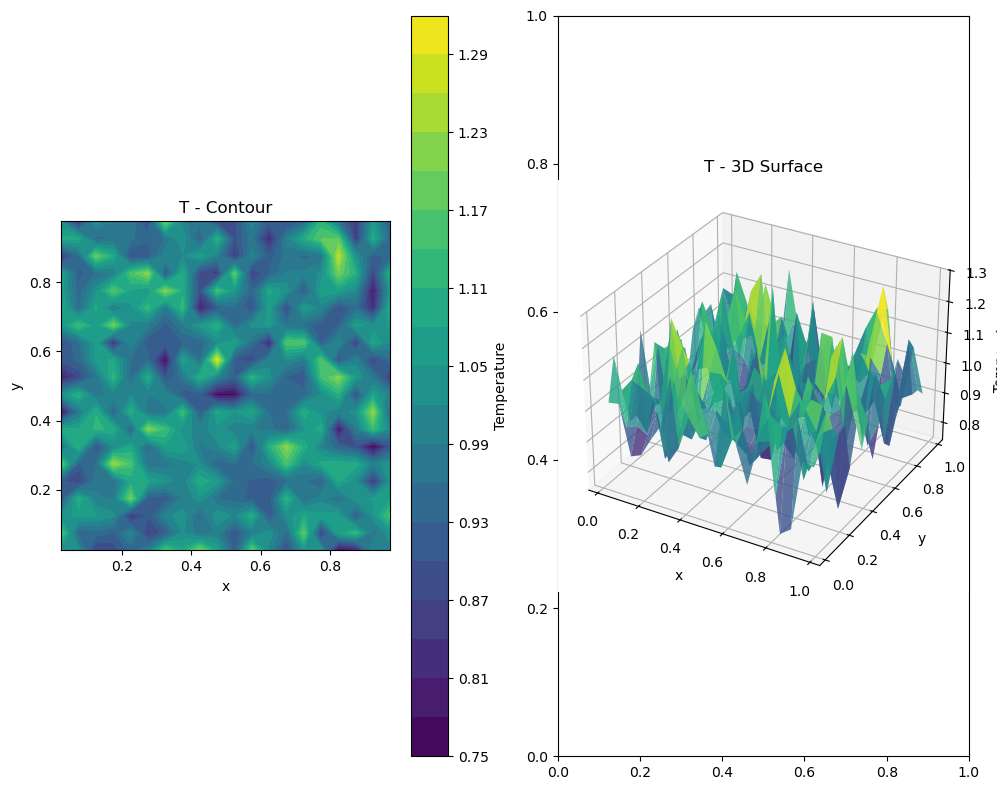

In [26]:
h = 1.0 / M
x = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
y = torch.linspace(0, 1, M+1, device=device)[:-1] + h/2
X, Y = torch.meshgrid(x, y, indexing='ij')

visualize_solution(final_sigma.detach().numpy(), X.detach().numpy(), Y.detach().numpy(), "T")

In [14]:
boundary_loss_history, regularization_loss_history

([1.4445243889937842e-09], [0.011781368404626846])

In [24]:
print(r2(sigma_gt, sigma_0))

-6.015038013458252


In [64]:
print((final_sigma - sigma_0).square().mean())

tensor(0.0097, grad_fn=<MeanBackward0>)


In [27]:
u_b_2 = get_boundary_conditions(1.5*final_sigma, source_func, T, max_sigma, device=device)

In [28]:
print((u_b_2 - u_b_gt).square().sum())

tensor(0., grad_fn=<SumBackward0>)


In [34]:
torch.max(u_b_gt), torch.min(u_b_gt)

(tensor(0.3183), tensor(0.))